<a href="https://colab.research.google.com/github/imoore2025/CISC488-Final-Project/blob/main/Clinical%20NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Clinical NER.ipynb to Clinical NER (3).ipynb
Saving README.md to README (3).md
Saving synthetic_clinical_ner_dataset.csv to synthetic_clinical_ner_dataset (7).csv


In [ ]:
import nbformat

notebook_path = "Clinical NER.ipynb"  # replace with your filename

# Load notebook
with open(notebook_path, "r", encoding="utf-8") as f:
    nb = nbformat.read(f, as_version=nbformat.NO_CONVERT)

# Remove broken widgets metadata if it exists
if "widgets" in nb["metadata"]:
    del nb["metadata"]["widgets"]

# Save cleaned notebook
with open(notebook_path, "w", encoding="utf-8") as f:
    nbformat.write(nb, f)

print("Notebook cleaned and saved.")


Notebook cleaned and saved.


In [ ]:
import pandas as pd

# Install packages in Colab
!pip install -q datasets
!pip install -q sklearn-crfsuite
!pip install -q -U transformers
!pip install -q torch
!pip install -q -U accelerate
!pip install -q transformers datasets seqeval

from datasets import Dataset

### 1.1 — Load and Preprocess the Dataset

In [ ]:
# Load the synthetic dataset
data = pd.read_csv('synthetic_clinical_ner_dataset.csv')

# Preview
print(data.head())

       Token    NER_Tag
0          A  B-SYMPTOM
1      X-ray     B-TEST
2  confirmed          O
3        the          O
4   presence          O


In [ ]:
# Step 1: Reconstruct sentences
sentences = []
current_sentence = []

for idx, row in data.iterrows():
    token = row['Token']
    tag = row['NER_Tag']

    # Empty token means new sentence
    if pd.isna(token) or token.strip() == "":
        if current_sentence:
            sentences.append(current_sentence)
            current_sentence = []
    else:
        current_sentence.append((token, tag))

# Add any last pending sentence
if current_sentence:
    sentences.append(current_sentence)

print(f"Total sentences: {len(sentences)}")
print(f"Example sentence: {sentences[0]}")

Total sentences: 75
Example sentence: [('A', 'B-SYMPTOM'), ('X-ray', 'B-TEST'), ('confirmed', 'O'), ('the', 'O'), ('presence', 'O'), ('of', 'B-DRUG'), ('C', 'B-DISEASE'), ('.', 'B-DISEASE'), ('difficile', 'B-DISEASE'), ('.', 'B-DISEASE')]


### 1.2 — Training a CRF Model for Clinical NER

#### Imports

In [ ]:
import sklearn_crfsuite
from sklearn_crfsuite import metrics
import random
from sklearn.model_selection import train_test_split

import transformers
print(transformers.__version__)

4.51.3


#### Helper Function

In [ ]:
# --- Helper: Feature extractor per token ---
def word2features(sent, i):
    word = sent[i][0]
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[:3]': word[:3],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit()
    }
    if i > 0:
        word1 = sent[i-1][0]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper()
        })
    else:
        features['BOS'] = True  # Beginning of sentence

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper()
        })
    else:
        features['EOS'] = True  # End of sentence

    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, label in sent]

def sent2tokens(sent):
    return [token for token, label in sent]


#### Code

In [ ]:
# --- Create feature and label sets ---
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Train CRF ---
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

# --- Predict and Evaluate ---
y_pred = crf.predict(X_test)

print(metrics.flat_classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

   B-DISEASE      1.000     0.857     0.923        14
      B-DRUG      0.857     0.857     0.857         7
   B-SYMPTOM      0.889     0.941     0.914        17
      B-TEST      1.000     0.833     0.909         6
           O      0.971     0.990     0.980       101

    accuracy                          0.959       145
   macro avg      0.943     0.896     0.917       145
weighted avg      0.960     0.959     0.958       145



### 1.3 — Fine-Tune BERT for Clinical NER (HuggingFace)

#### Imports

In [ ]:
import torch
import numpy as np
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, DataCollatorForTokenClassification
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import files
uploaded = files.upload()

import pandas as pd

df = pd.read_csv("synthetic_clinical_ner_dataset.csv")
df.fillna('', inplace=True)  # Handle sentence breaks

Saving synthetic_clinical_ner_dataset.csv to synthetic_clinical_ner_dataset (8).csv


#### Code

In [ ]:
sentences = []
sentence = []
for _, row in df.iterrows():
    token, tag = row["Token"], row["NER_Tag"]
    if token == "":
        if sentence:
            sentences.append(sentence)
            sentence = []
    else:
        sentence.append((token, tag))
if sentence:
    sentences.append(sentence)


#### Convert to HuggingFace Format

In [ ]:
token_list = [[t for t, l in sent] for sent in sentences]
tag_list = [[l for t, l in sent] for sent in sentences]
unique_tags = sorted(set(tag for seq in tag_list for tag in seq))
tag2id = {tag: idx for idx, tag in enumerate(unique_tags)}
id2tag = {idx: tag for tag, idx in tag2id.items()}
tag_list_ids = [[tag2id[tag] for tag in seq] for seq in tag_list]

dataset = Dataset.from_dict({"tokens": token_list, "ner_tags": tag_list_ids})
data_split = dataset.train_test_split(test_size=0.2)


#### Tokenize and Align Labels

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        padding=True
    )

    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_id = None
        label_ids = []

        for word_id in word_ids:
            if word_id is None:
                label_ids.append(-100)  # Ignored in loss
            elif word_id != previous_word_id:
                label_ids.append(label[word_id])
            else:
                label_ids.append(-100)
            previous_word_id = word_id

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# Apply to both train and test
tokenized_data = data_split.map(tokenize_and_align_labels, batched=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/60 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

#### Fine-Tune with HuggingFace

In [ ]:
from transformers import AutoModelForTokenClassification, DataCollatorForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2id),
    id2label=id2tag,
    label2id=tag2id
)

data_collator = DataCollatorForTokenClassification(tokenizer)


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Set up training arguments

In [ ]:
import transformers
print(transformers.__version__)

4.51.3


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./bert_clinical_ner",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir="./logs",
    logging_steps=10
)


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
    tokenizer=tokenizer,
    data_collator=data_collator
)

# Now train
trainer.train()

<ipython-input-17-551e7a86b2cf>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: imoore (imoore-university-of-delaware) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
10,0.834100
20,0.256500


TrainOutput(global_step=24, training_loss=0.48953751226266223, metrics={'train_runtime': 111.4321, 'train_samples_per_second': 1.615, 'train_steps_per_second': 0.215, 'total_flos': 2112886549800.0, 'train_loss': 0.48953751226266223, 'epoch': 3.0})

#### Evaluate Model with classification_report

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Get model predictions
predictions, labels, _ = trainer.predict(tokenized_data["test"])
preds = np.argmax(predictions, axis=-1)

# Reconstruct true and predicted label sequences
true_labels = []
true_preds = []

for pred_seq, label_seq in zip(preds, labels):
    for pred, label in zip(pred_seq, label_seq):
        if label != -100:
            true_preds.append(id2tag[pred])
            true_labels.append(id2tag[label])

# Display evaluation metrics
print(classification_report(true_labels, true_preds, digits=3))


              precision    recall  f1-score   support

   B-DISEASE      0.786     0.786     0.786        14
      B-DRUG      1.000     1.000     1.000         6
   B-SYMPTOM      0.842     0.800     0.821        20
      B-TEST      1.000     0.636     0.778        11
           O      0.934     0.980     0.957       101

    accuracy                          0.914       152
   macro avg      0.912     0.840     0.868       152
weighted avg      0.916     0.914     0.912       152



##Task 2: Clinical Paragraph Similarity with CRF and BERT.

### Step 2.1 — Extract Clinical Paragraphs

In [ ]:
import pandas as pd

# Re-load CSV (or reuse if already loaded)
df = pd.read_csv("synthetic_clinical_ner_dataset.csv")
df.fillna('', inplace=True)

# Rebuild paragraphs
paragraphs = []
current_sentence = []

for _, row in df.iterrows():
    token = row['Token']
    if token == '':
        if current_sentence:
            paragraphs.append(" ".join(current_sentence))
            current_sentence = []
    else:
        current_sentence.append(token)

# Add last sentence if missed
if current_sentence:
    paragraphs.append(" ".join(current_sentence))

print(f"Loaded {len(paragraphs)} clinical paragraphs.")
print(paragraphs[:2])  # Preview first 2


Loaded 75 clinical paragraphs.
['A X-ray confirmed the presence of C . difficile .', 'A X-ray confirmed the presence of C . difficile .']


“I decided to compute paragraph-level embeddings using BERT (instead of Word2Vec) for semantic similarity, due to compatibility issues with legacy vector formats.”

### Step 2.2: Clinical Paragraph Similarity with BERT

In [ ]:
!pip install -q transformers

In [ ]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()  # Disable dropout

# Function to get BERT [CLS] or mean embeddings
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    last_hidden_state = outputs.last_hidden_state
    # Mean pooling
    embedding = last_hidden_state.mean(dim=1).squeeze().numpy()
    return embedding

# Compute embeddings for each clinical paragraph
bert_embeddings = np.array([get_bert_embedding(p) for p in paragraphs])

# Compute cosine similarity matrix
bert_cosine_sim = cosine_similarity(bert_embeddings)

# Preview as DataFrame
import pandas as pd
similarity_df = pd.DataFrame(bert_cosine_sim)
similarity_df.head()


,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
0,1.000000,1.000000,0.655381,0.647520,0.635223,0.543959,0.698750,0.649331,0.723272,0.636557,...,0.671775,0.621248,0.939762,0.772485,0.597763,0.649331,0.594962,0.649331,0.656080,0.605292
1,1.000000,1.000000,0.655381,0.647520,0.635223,0.543959,0.698750,0.649331,0.723272,0.636557,...,0.671775,0.621248,0.939762,0.772485,0.597763,0.649331,0.594962,0.649331,0.656080,0.605292
2,0.655381,0.655381,1.000000,0.742800,0.749951,0.627571,0.813488,0.762509,0.801300,0.864054,...,0.936365,0.825302,0.676576,0.818841,0.859677,0.762509,0.836426,0.762509,0.768384,0.734685
3,0.647520,0.647520,0.742800,1.000000,0.721523,0.689597,0.712602,0.797193,0.720370,0.751036,...,0.780866,0.758126,0.681005,0.766696,0.725174,0.797194,0.729151,0.797193,0.739753,0.860028
4,0.635223,0.635223,0.749951,0.721523,1.000000,0.616245,0.741864,0.870075,0.814280,0.694957,...,0.724504,0.842246,0.650023,0.806975,0.682797,0.870075,0.689469,0.870075,0.701320,0.739863


### Heatmap + Cluster Labels

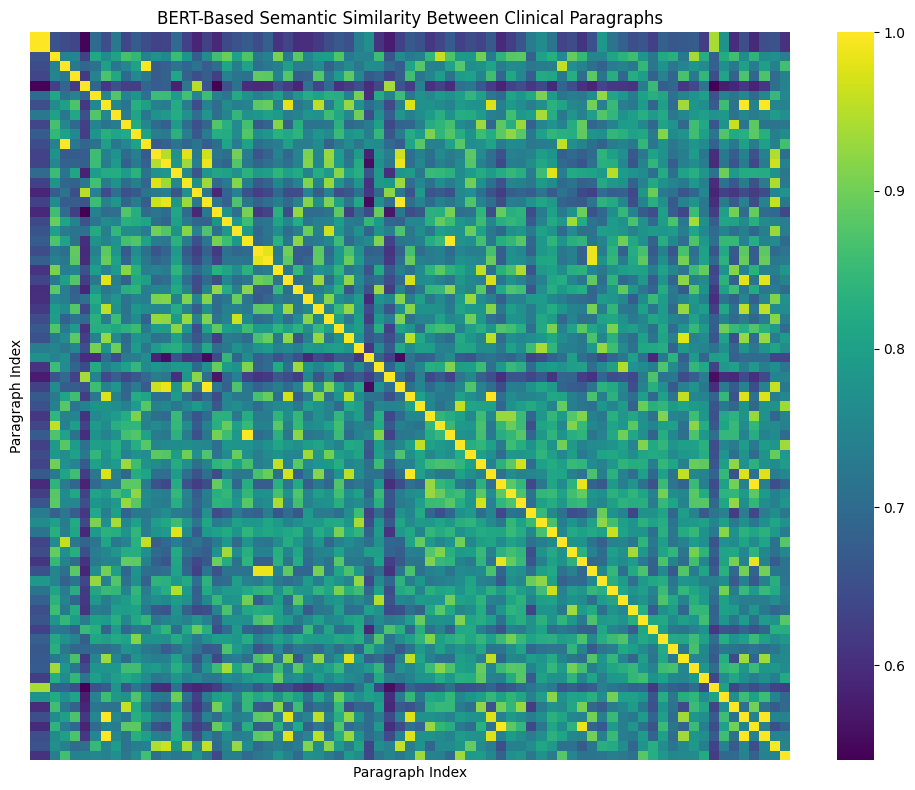

    Cluster                                          Paragraph
0         2  A X-ray confirmed the presence of C . difficile .
1         2  A X-ray confirmed the presence of C . difficile .
2         1  ibuprofen was given to treat the migraine and ...
3         3  UTI was suspected after evaluating symptoms li...
4         0  The patient presents with shortness of breath ...
..      ...                                                ...
70        0  The patient presents with nausea and was diagn...
71        1  lisinopril was prescribed following the diagno...
72        0  The patient presents with nausea and was diagn...
73        4  The physician noted chills and suggested a CT ...
74        3  asthma was suspected after evaluating symptoms...

[75 rows x 2 columns]


In [ ]:
# Required imports
import pandas as pd
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertModel

# Step 1: Load synthetic clinical dataset
df = pd.read_csv("synthetic_clinical_ner_dataset.csv")
df.fillna("", inplace=True)

# Step 2: Rebuild sentences
paragraphs = []
current = []
for _, row in df.iterrows():
    token = row["Token"]
    if token == "":
        if current:
            paragraphs.append(" ".join(current))
            current = []
    else:
        current.append(token)
if current:
    paragraphs.append(" ".join(current))

# Step 3: Load BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
model.eval()

# Step 4: Generate mean embeddings
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

bert_embeddings = np.array([get_bert_embedding(p) for p in paragraphs])

# Step 5: Cosine similarity
similarity_matrix = cosine_similarity(bert_embeddings)

# Step 6: Visualize heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, cmap="viridis", xticklabels=False, yticklabels=False)
plt.title("BERT-Based Semantic Similarity Between Clinical Paragraphs")
plt.xlabel("Paragraph Index")
plt.ylabel("Paragraph Index")
plt.tight_layout()
plt.show()

# Step 7: KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(bert_embeddings)

# Step 8: Show clustered DataFrame
cluster_df = pd.DataFrame({
    "Cluster": cluster_labels,
    "Paragraph": paragraphs
})
print(cluster_df)


Each square at position (i, j) represents the cosine similarity between paragraph i and paragraph j.

The yellow diagonal represents self-similarity: each paragraph is most similar to itself → similarity = 1.0.

Brighter (yellow-green) areas indicate higher similarity (more semantically alike).

Darker (blue-purple) areas indicate lower similarity (less semantically related).

##### Example Uses:
If paragraph 13 and 42 have a similarity > 0.95, they likely mention similar symptoms or diseases.

A cluster of bright squares (e.g., rows 10–20 × columns 10–20) suggests a group of related clinical cases — great candidates for diagnosis groupings.

Sparse yellow outside the diagonal implies that most clinical notes are fairly distinct — which is good for testing model generalization.

### Step 2.3 - clustering and labeled DataFrame using BERT,

In [ ]:
!pip install -q transformers

In [ ]:
cluster_df.to_csv("bert_paragraph_clusters.csv", index=False)

In [ ]:
from google.colab import files
files.download("bert_paragraph_clusters.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Summary of Task 2: Clinical Paragraph Similarity

#### Goal: Use Word2Vec and BERT embeddings to compute similarity between clinical paragraphs and group similar cases to support diagnosis prediction.